In [1]:
import torch
import requests
from tabpfn import TabPFNClassifier
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, drop=None, target=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [4]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [5]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

In [6]:
Noise_0_dataset_era = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [int(len(Noise_0_dataset_era)*0.8), int(len(Noise_0_dataset_era)*0.2)])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [int(len(Noise_Low_dataset_era)*0.8), int(len(Noise_Low_dataset_era)*0.2)])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [int(len(Noise_High_dataset_era)*0.8), int(len(Noise_High_dataset_era)*0.2)])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [int(len(Noise_Low_dataset_t10v)*0.8), int(len(Noise_Low_dataset_t10v)*0.2)])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [int(len(Noise_High_dataset_t10v)*0.8), int(len(Noise_High_dataset_t10v)*0.2)])

In [7]:
#Setting batch_size=1000 for target_10_Val as tabpfn requires 1000 rows max

#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=512, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=512, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=512, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=1000, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=512, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=1000, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=512, shuffle=True)

In [8]:
class EncoderClassifier(torch.nn.Module):
    def __init__(self, encoder, latent_dim, layers, subset_size, overlap, activation=torch.nn.ReLU()):
        super().__init__()
        self.encoder = encoder
        self.layers = []
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.latent_layer = torch.nn.Linear(latent_dim, layers[0])
        
        for i in range(len(linear)):
            if (i == 0 or i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)

        self.layers = torch.nn.Sequential(*self.layers)
        self.subset_size = subset_size
        self.overlap = overlap
        self.softmax = torch.nn.Softmax(dim=1)
        self.att_layer = torch.nn.Linear(latent_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.lrelu = activation

    def forward(self, X):
        subsets = []
        num_columns = X.shape[1]
        for i in range(0, num_columns-self.subset_size, self.subset_size-self.overlap):
            subsets.append(X[:, i:i+self.subset_size])

        preds = 0
        h = 0
        for subset in subsets:
            pred = self.encoder(subset)
            pred = self.latent_layer(pred)
            h = self.att_layer(pred)
            pred = self.lrelu(pred)
            pred = self.layers(pred)
            pred = self.softmax(pred)
            preds += pred

        h = h/len(subsets)
        h = self.sigmoid(h)
        preds = preds/len(subsets)

        return preds, h

In [9]:
class SubsetAutoencoder (torch.nn.Module):
    def __init__(self, encoder_sizes,decoder_sizes,activation = torch.nn.ReLU()):
        super().__init__()
        linear_encoder = [torch.nn.Linear(encoder_sizes[i],encoder_sizes[i+1]) for i in range(len(encoder_sizes)-1)]
        linear_decoder = [torch.nn.Linear(decoder_sizes[i],decoder_sizes[i+1]) for i in range(len(decoder_sizes)-1)]
        self.encoder = torch.nn.Sequential(*[l for layer in linear_encoder for l in (layer, activation)])
        self.decoder = torch.nn.Sequential(*[l for layer in linear_decoder for l in (layer, activation)])
        
    def forward(self,X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X
    
    def get_encoder(self):
        return self.encoder
    
    def get_decoder(self):
        return self.decoder

In [10]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self,reg,no_of_class=12):
        super(CustomLoss, self).__init__()
        self.reg=reg
        self.no_of_class=no_of_class

    def forward(self, inputs, targets):
        p=torch.Tensor(inputs[0]).to(device).t()
        # Converting to 64 X 12 to 64 X 1
        # _,p=torch.max(p,1)
        targets=torch.eye(self.no_of_class).to(device)[targets].t()
        tou=torch.Tensor(inputs[1]).to(device)
        tou=tou.t()
        # print("tou",tou)
        # print(tou)
        loss_a= torch.t(targets)@torch.log(tou*(p-targets)+targets)
        loss_b=self.reg*torch.log(tou)
        loss_a=loss_a.diag().t()
        # print("Loss a",loss_a)
        # print("Loss b",loss_b)
        loss=loss_a+loss_b
        # print("loss",loss.shape)
        # print("return",loss.mean().shape)
        return -loss.mean()

    def custom_p(p):
        return p

In [11]:
def get_subsets(current_batch,subset_size,overlap):
        subsets = []
        num_columns = current_batch.shape[1]
        for i in range(0, num_columns-subset_size,subset_size-overlap):
            subsets.append(current_batch[:,i:i+subset_size])
        return subsets


def train_ae(model,criterion,optimizer,epochs,trainloader,testloader,subset_size = 10,overlap = 4,lr = 0.001 , verbose = True):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        current_train_loss = 0
        current_accuracy = []
        for data, _ in tqdm(trainloader,desc = "Training Epoch "+str(epoch)):
            data= data.to(device).float()
            subsets = get_subsets(data,subset_size,overlap)
            optimizer.zero_grad()
            recons = []
            subset_loss = 0
            for subset in subsets:
                output = model(subset)
                recons.append(output)
                subset_loss += criterion(data,output)
            subset_loss = subset_loss.mean()
            subset_loss.backward()
            optimizer.step()
        print(f"epoch-{epoch} loss:",subset_loss)
        
def train_classifier(model,criterion,optimizer,epochs,trainloader,testloader,lr=0.001,verbose = True,subset_size = 10,overlap = 2):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        running_train_loss = 0
        total_train = 0
        correct_train = 0
        current_accuracy = []
        for data, target in tqdm(trainloader,desc = "Training Epoch "+str(epoch)):
            data, target = data.to(device).float(), target.to(device).long()
            subsets = get_subsets(data,subset_size,overlap)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output[0], 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            current_accuracy.append(correct_train/total_train)
            running_train_loss+=loss
        
        running_train_loss /= len(trainloader)    
        print(f"epoch-{epoch} loss:{running_train_loss} accuracy:{correct_train/total_train}")

In [12]:
def train_classifier(model, criterion, optimizer, epochs, trainloader, testloader, lr=0.001, verbose=True, subset_size=10, overlap=2):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(epochs):
        running_train_loss = 0
        total_train = 0
        correct_train = 0
        
        # Training
        model.train()
        for data, target in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data, target = data.to(device).float(), target.to(device).long()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output[0], 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            running_train_loss += loss.item()
            
        accuracy = correct_train / total_train
        train_accuracy.append(accuracy)
        running_train_loss /= len(trainloader)
        train_loss.append(running_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0
        total_val = 0
        correct_val = 0
        with torch.no_grad():
            for data, target in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data, target = data.to(device).float(), target.to(device).long()
                output = model(data)
                loss = criterion(output, target)
                running_val_loss += loss.item()
                
                _, predicted = torch.max(output[0], 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        running_val_loss /= len(testloader)
        val_loss.append(running_val_loss)
        accuracy_val = correct_val / total_val
        val_accuracy.append(accuracy_val)
        
        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {accuracy:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {accuracy_val:.4f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    return train_loss, val_loss, train_accuracy, val_accuracy

In [13]:
def train_ae(model, criterion, optimizer, epochs, trainloader, testloader, subset_size=10, overlap=4, lr=0.001, verbose=True):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        # Training
        model.train()
        current_train_loss = 0
        for data, _ in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data = data.to(device).float()
            subsets = get_subsets(data, subset_size, overlap)
            optimizer.zero_grad()
            recons = []
            subset_loss = 0
            for subset in subsets:
                output = model(subset)
                recons.append(output)
                subset_loss += criterion(data, output)
            subset_loss = subset_loss.mean()
            subset_loss.backward()
            optimizer.step()
            current_train_loss += subset_loss.item() * data.size(0)
        train_loss.append(current_train_loss / len(trainloader.dataset))
        
        # Validation
        model.eval()
        current_val_loss = 0
        with torch.no_grad():
            for data, _ in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data = data.to(device).float()
                subsets = get_subsets(data, subset_size, overlap)
                recons = []
                subset_loss = 0
                for subset in subsets:
                    output = model(subset)
                    recons.append(output)
                    subset_loss += criterion(data, output)
                subset_loss = subset_loss.mean()
                current_val_loss += subset_loss.item() * data.size(0)
            val_loss.append(current_val_loss / len(testloader.dataset))
        
        if verbose:
            print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return train_loss, val_loss

Training Epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 107.23it/s]


Epoch [0/50], Train Loss: 0.047341288679327145, Validation Loss: 0.02146638842538381


Validation Epoch 1: 100%|██████████| 122/122 [00:01<00:00, 110.38it/s]


Epoch [1/50], Train Loss: 0.01943980736914688, Validation Loss: 0.017899364966612596


Validation Epoch 2: 100%|██████████| 122/122 [00:00<00:00, 134.58it/s]


Epoch [2/50], Train Loss: 0.017050198956171814, Validation Loss: 0.01638901923329402


Validation Epoch 3: 100%|██████████| 122/122 [00:00<00:00, 142.79it/s]


Epoch [3/50], Train Loss: 0.015979768661334395, Validation Loss: 0.015615557042452006


Validation Epoch 4: 100%|██████████| 122/122 [00:00<00:00, 137.66it/s]


Epoch [4/50], Train Loss: 0.015421944319640692, Validation Loss: 0.014959028364183048


Validation Epoch 5: 100%|██████████| 122/122 [00:00<00:00, 123.73it/s]


Epoch [5/50], Train Loss: 0.015008649427610904, Validation Loss: 0.014640011438765588


Validation Epoch 6: 100%|██████████| 122/122 [00:00<00:00, 133.80it/s]


Epoch [6/50], Train Loss: 0.014613803329083543, Validation Loss: 0.014514146454823323


Validation Epoch 7: 100%|██████████| 122/122 [00:00<00:00, 137.95it/s]


Epoch [7/50], Train Loss: 0.014402609447596403, Validation Loss: 0.014292257224711087


Validation Epoch 8: 100%|██████████| 122/122 [00:00<00:00, 123.66it/s]


Epoch [8/50], Train Loss: 0.014262837924970647, Validation Loss: 0.014151056750844687


Validation Epoch 9: 100%|██████████| 122/122 [00:00<00:00, 126.66it/s]


Epoch [9/50], Train Loss: 0.014156170417733777, Validation Loss: 0.013958838870510077


Validation Epoch 10: 100%|██████████| 122/122 [00:01<00:00, 121.49it/s]


Epoch [10/50], Train Loss: 0.014098470648511862, Validation Loss: 0.014361781047131771


Validation Epoch 11: 100%|██████████| 122/122 [00:01<00:00, 114.96it/s]


Epoch [11/50], Train Loss: 0.014028186948659519, Validation Loss: 0.014427275437001999


Validation Epoch 12: 100%|██████████| 122/122 [00:01<00:00, 118.82it/s]


Epoch [12/50], Train Loss: 0.013942493584741337, Validation Loss: 0.014073485976610428


Validation Epoch 13: 100%|██████████| 122/122 [00:00<00:00, 127.95it/s]


Epoch [13/50], Train Loss: 0.013863805899372658, Validation Loss: 0.01394465372348443


Validation Epoch 14: 100%|██████████| 122/122 [00:00<00:00, 126.30it/s]


Epoch [14/50], Train Loss: 0.013801432123634582, Validation Loss: 0.013600684689023555


Validation Epoch 15: 100%|██████████| 122/122 [00:01<00:00, 119.39it/s]


Epoch [15/50], Train Loss: 0.01377254772486571, Validation Loss: 0.014176038115834578


Validation Epoch 16: 100%|██████████| 122/122 [00:01<00:00, 102.20it/s]


Epoch [16/50], Train Loss: 0.013783321406196754, Validation Loss: 0.013552350009290072


Validation Epoch 17: 100%|██████████| 122/122 [00:01<00:00, 97.01it/s]


Epoch [17/50], Train Loss: 0.013654919247178791, Validation Loss: 0.013654692338254207


Validation Epoch 18: 100%|██████████| 122/122 [00:00<00:00, 129.66it/s]


Epoch [18/50], Train Loss: 0.013625230566294003, Validation Loss: 0.013766334985311214


Validation Epoch 19: 100%|██████████| 122/122 [00:00<00:00, 127.20it/s]


Epoch [19/50], Train Loss: 0.013593765955495959, Validation Loss: 0.013654512067635854


Validation Epoch 20: 100%|██████████| 122/122 [00:00<00:00, 129.08it/s]


Epoch [20/50], Train Loss: 0.01361487848379721, Validation Loss: 0.013803117429980865


Validation Epoch 21: 100%|██████████| 122/122 [00:00<00:00, 129.96it/s]


Epoch [21/50], Train Loss: 0.01353466393909632, Validation Loss: 0.013886257346050862


Validation Epoch 22: 100%|██████████| 122/122 [00:00<00:00, 162.11it/s]


Epoch [22/50], Train Loss: 0.013529337338136079, Validation Loss: 0.013344211798065749


Validation Epoch 23: 100%|██████████| 122/122 [00:01<00:00, 93.95it/s]


Epoch [23/50], Train Loss: 0.013496014735070415, Validation Loss: 0.013333285624782244


Validation Epoch 24: 100%|██████████| 122/122 [00:01<00:00, 118.47it/s]


Epoch [24/50], Train Loss: 0.013428600257238707, Validation Loss: 0.013493382306053089


Validation Epoch 25: 100%|██████████| 122/122 [00:01<00:00, 107.30it/s]


Epoch [25/50], Train Loss: 0.013527695226889009, Validation Loss: 0.013659884612529706


Validation Epoch 26: 100%|██████████| 122/122 [00:00<00:00, 133.09it/s]


Epoch [26/50], Train Loss: 0.013474135540980989, Validation Loss: 0.013260087347947635


Validation Epoch 27: 100%|██████████| 122/122 [00:00<00:00, 142.40it/s]


Epoch [27/50], Train Loss: 0.013430981219967063, Validation Loss: 0.013169660886319785


Validation Epoch 28: 100%|██████████| 122/122 [00:00<00:00, 142.84it/s]


Epoch [28/50], Train Loss: 0.013370432981994385, Validation Loss: 0.013391145930076257


Validation Epoch 29: 100%|██████████| 122/122 [00:00<00:00, 136.77it/s]


Epoch [29/50], Train Loss: 0.013361590452498207, Validation Loss: 0.013237754128491267


Validation Epoch 30: 100%|██████████| 122/122 [00:00<00:00, 138.42it/s]


Epoch [30/50], Train Loss: 0.013370814321276087, Validation Loss: 0.013398685092345262


Validation Epoch 31: 100%|██████████| 122/122 [00:01<00:00, 101.80it/s]


Epoch [31/50], Train Loss: 0.01335118850469231, Validation Loss: 0.013425264472189622


Validation Epoch 32: 100%|██████████| 122/122 [00:01<00:00, 119.03it/s]


Epoch [32/50], Train Loss: 0.013277082816691687, Validation Loss: 0.013450125575256653


Validation Epoch 33: 100%|██████████| 122/122 [00:00<00:00, 140.21it/s]


Epoch [33/50], Train Loss: 0.013330574030987918, Validation Loss: 0.01324446445187697


Validation Epoch 34: 100%|██████████| 122/122 [00:00<00:00, 142.76it/s]


Epoch [34/50], Train Loss: 0.013315031645246424, Validation Loss: 0.013104954264484919


Validation Epoch 35: 100%|██████████| 122/122 [00:00<00:00, 152.74it/s]


Epoch [35/50], Train Loss: 0.013222169216113308, Validation Loss: 0.013106743406790954


Validation Epoch 36: 100%|██████████| 122/122 [00:01<00:00, 108.72it/s]


Epoch [36/50], Train Loss: 0.013268381109437307, Validation Loss: 0.013434793552718101


Validation Epoch 37: 100%|██████████| 122/122 [00:01<00:00, 109.30it/s]


Epoch [37/50], Train Loss: 0.013336193079176622, Validation Loss: 0.013469936350026192


Validation Epoch 38: 100%|██████████| 122/122 [00:01<00:00, 116.08it/s]


Epoch [38/50], Train Loss: 0.013234047304229954, Validation Loss: 0.013692471756575963


Validation Epoch 39: 100%|██████████| 122/122 [00:01<00:00, 104.09it/s]


Epoch [39/50], Train Loss: 0.013182602106378628, Validation Loss: 0.012937968151691633


Validation Epoch 40: 100%|██████████| 122/122 [00:00<00:00, 149.51it/s]


Epoch [40/50], Train Loss: 0.013229319528013898, Validation Loss: 0.013246002377798924


Validation Epoch 41: 100%|██████████| 122/122 [00:00<00:00, 130.85it/s]


Epoch [41/50], Train Loss: 0.013255995289327051, Validation Loss: 0.01306591249238222


Validation Epoch 42: 100%|██████████| 122/122 [00:01<00:00, 103.69it/s]


Epoch [42/50], Train Loss: 0.013134633655844925, Validation Loss: 0.01330012520058797


Validation Epoch 43: 100%|██████████| 122/122 [00:01<00:00, 104.44it/s]


Epoch [43/50], Train Loss: 0.01321591976030061, Validation Loss: 0.013223626291713654


Validation Epoch 44: 100%|██████████| 122/122 [00:00<00:00, 130.51it/s]


Epoch [44/50], Train Loss: 0.013176933511530455, Validation Loss: 0.013372119322228126


Validation Epoch 45: 100%|██████████| 122/122 [00:00<00:00, 127.99it/s]


Epoch [45/50], Train Loss: 0.013138068495139193, Validation Loss: 0.013434800520921365


Validation Epoch 46: 100%|██████████| 122/122 [00:01<00:00, 117.87it/s]


Epoch [46/50], Train Loss: 0.013149468721493553, Validation Loss: 0.012870163807693201


Validation Epoch 47: 100%|██████████| 122/122 [00:00<00:00, 140.64it/s]


Epoch [47/50], Train Loss: 0.013090214610714704, Validation Loss: 0.013139878143675817


Validation Epoch 48: 100%|██████████| 122/122 [00:00<00:00, 147.92it/s]


Epoch [48/50], Train Loss: 0.013039181760410802, Validation Loss: 0.012933659685345796


Validation Epoch 49: 100%|██████████| 122/122 [00:01<00:00, 97.47it/s] 


Epoch [49/50], Train Loss: 0.013114527202933693, Validation Loss: 0.01290435023414783


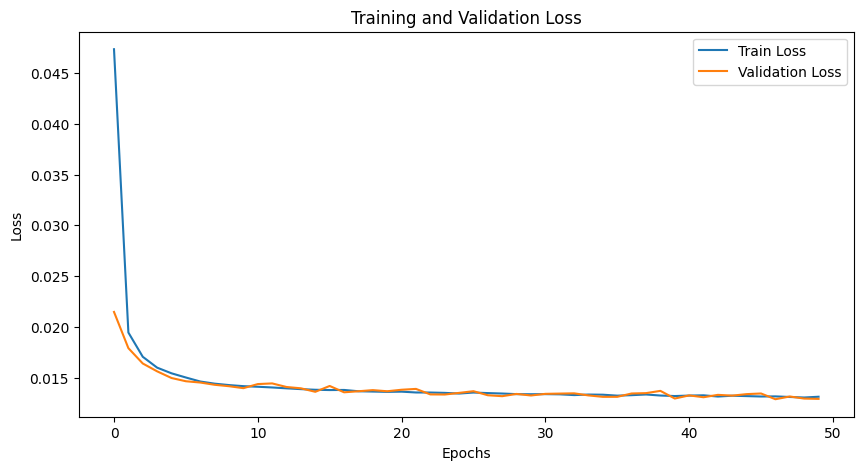

([0.047341288679327145,
  0.01943980736914688,
  0.017050198956171814,
  0.015979768661334395,
  0.015421944319640692,
  0.015008649427610904,
  0.014613803329083543,
  0.014402609447596403,
  0.014262837924970647,
  0.014156170417733777,
  0.014098470648511862,
  0.014028186948659519,
  0.013942493584741337,
  0.013863805899372658,
  0.013801432123634582,
  0.01377254772486571,
  0.013783321406196754,
  0.013654919247178791,
  0.013625230566294003,
  0.013593765955495959,
  0.01361487848379721,
  0.01353466393909632,
  0.013529337338136079,
  0.013496014735070415,
  0.013428600257238707,
  0.013527695226889009,
  0.013474135540980989,
  0.013430981219967063,
  0.013370432981994385,
  0.013361590452498207,
  0.013370814321276087,
  0.01335118850469231,
  0.013277082816691687,
  0.013330574030987918,
  0.013315031645246424,
  0.013222169216113308,
  0.013268381109437307,
  0.013336193079176622,
  0.013234047304229954,
  0.013182602106378628,
  0.013229319528013898,
  0.01325599528932705

In [23]:
model = SubsetAutoencoder(encoder_sizes=[18,32,22],decoder_sizes=[22,32,24])
model.to(device)
optimizer = torch.optim.Adam
criterion = torch.nn.MSELoss()
train_ae(model,criterion,optimizer,50,Noise_Low_t10v_train_loader,Noise_Low_t10v_test_loader,subset_size = 18,overlap = 6,lr=0.01)

Validation Epoch 108: 100%|██████████| 122/122 [00:01<00:00, 84.47it/s]


Epoch [109/150], Train Loss: 0.8429, Train Accuracy: 0.6928, Validation Loss: 0.8416, Validation Accuracy: 0.6946


Validation Epoch 109: 100%|██████████| 122/122 [00:01<00:00, 110.91it/s]


Epoch [110/150], Train Loss: 0.8417, Train Accuracy: 0.6935, Validation Loss: 0.8402, Validation Accuracy: 0.6934


Validation Epoch 110: 100%|██████████| 122/122 [00:01<00:00, 91.90it/s]


Epoch [111/150], Train Loss: 0.8411, Train Accuracy: 0.6942, Validation Loss: 0.8401, Validation Accuracy: 0.6947


Validation Epoch 111: 100%|██████████| 122/122 [00:01<00:00, 91.88it/s] 


Epoch [112/150], Train Loss: 0.8406, Train Accuracy: 0.6947, Validation Loss: 0.8403, Validation Accuracy: 0.6954


Validation Epoch 112: 100%|██████████| 122/122 [00:01<00:00, 106.08it/s]


Epoch [113/150], Train Loss: 0.8392, Train Accuracy: 0.6946, Validation Loss: 0.8383, Validation Accuracy: 0.6949


Validation Epoch 113: 100%|██████████| 122/122 [00:01<00:00, 103.29it/s]


Epoch [114/150], Train Loss: 0.8389, Train Accuracy: 0.6954, Validation Loss: 0.8379, Validation Accuracy: 0.6919


Validation Epoch 114: 100%|██████████| 122/122 [00:01<00:00, 82.65it/s]


Epoch [115/150], Train Loss: 0.8382, Train Accuracy: 0.6950, Validation Loss: 0.8375, Validation Accuracy: 0.6951


Validation Epoch 115: 100%|██████████| 122/122 [00:01<00:00, 85.18it/s]


Epoch [116/150], Train Loss: 0.8374, Train Accuracy: 0.6960, Validation Loss: 0.8377, Validation Accuracy: 0.6933


Validation Epoch 116: 100%|██████████| 122/122 [00:01<00:00, 84.14it/s]


Epoch [117/150], Train Loss: 0.8359, Train Accuracy: 0.6964, Validation Loss: 0.8341, Validation Accuracy: 0.6973


Validation Epoch 117: 100%|██████████| 122/122 [00:01<00:00, 89.44it/s] 


Epoch [118/150], Train Loss: 0.8308, Train Accuracy: 0.6981, Validation Loss: 0.8269, Validation Accuracy: 0.6995


Validation Epoch 118: 100%|██████████| 122/122 [00:01<00:00, 96.33it/s] 


Epoch [119/150], Train Loss: 0.8237, Train Accuracy: 0.7022, Validation Loss: 0.8194, Validation Accuracy: 0.7039


Validation Epoch 119: 100%|██████████| 122/122 [00:01<00:00, 108.12it/s]


Epoch [120/150], Train Loss: 0.8179, Train Accuracy: 0.7040, Validation Loss: 0.8146, Validation Accuracy: 0.7060


Validation Epoch 120: 100%|██████████| 122/122 [00:01<00:00, 108.12it/s]


Epoch [121/150], Train Loss: 0.8127, Train Accuracy: 0.7070, Validation Loss: 0.8117, Validation Accuracy: 0.7070


Validation Epoch 121: 100%|██████████| 122/122 [00:01<00:00, 121.97it/s]


Epoch [122/150], Train Loss: 0.8101, Train Accuracy: 0.7069, Validation Loss: 0.8072, Validation Accuracy: 0.7074


Validation Epoch 122: 100%|██████████| 122/122 [00:01<00:00, 101.29it/s]


Epoch [123/150], Train Loss: 0.8066, Train Accuracy: 0.7080, Validation Loss: 0.8062, Validation Accuracy: 0.7086


Validation Epoch 123: 100%|██████████| 122/122 [00:01<00:00, 84.70it/s]


Epoch [124/150], Train Loss: 0.8050, Train Accuracy: 0.7086, Validation Loss: 0.8044, Validation Accuracy: 0.7080


Validation Epoch 124: 100%|██████████| 122/122 [00:01<00:00, 102.21it/s]


Epoch [125/150], Train Loss: 0.8026, Train Accuracy: 0.7093, Validation Loss: 0.8006, Validation Accuracy: 0.7087


Validation Epoch 125: 100%|██████████| 122/122 [00:01<00:00, 95.73it/s] 


Epoch [126/150], Train Loss: 0.8012, Train Accuracy: 0.7093, Validation Loss: 0.7991, Validation Accuracy: 0.7140


Validation Epoch 126: 100%|██████████| 122/122 [00:01<00:00, 99.71it/s] 


Epoch [127/150], Train Loss: 0.7999, Train Accuracy: 0.7102, Validation Loss: 0.7983, Validation Accuracy: 0.7090


Validation Epoch 127: 100%|██████████| 122/122 [00:01<00:00, 89.79it/s]


Epoch [128/150], Train Loss: 0.7985, Train Accuracy: 0.7104, Validation Loss: 0.7978, Validation Accuracy: 0.7153


Validation Epoch 128: 100%|██████████| 122/122 [00:01<00:00, 97.78it/s] 


Epoch [129/150], Train Loss: 0.7972, Train Accuracy: 0.7110, Validation Loss: 0.7960, Validation Accuracy: 0.7110


Validation Epoch 129: 100%|██████████| 122/122 [00:01<00:00, 71.88it/s]


Epoch [130/150], Train Loss: 0.7966, Train Accuracy: 0.7124, Validation Loss: 0.7980, Validation Accuracy: 0.7109


Validation Epoch 130: 100%|██████████| 122/122 [00:01<00:00, 93.16it/s] 


Epoch [131/150], Train Loss: 0.7957, Train Accuracy: 0.7119, Validation Loss: 0.7946, Validation Accuracy: 0.7116


Validation Epoch 131: 100%|██████████| 122/122 [00:01<00:00, 87.58it/s]


Epoch [132/150], Train Loss: 0.7940, Train Accuracy: 0.7116, Validation Loss: 0.7928, Validation Accuracy: 0.7097


Validation Epoch 132: 100%|██████████| 122/122 [00:01<00:00, 87.64it/s]


Epoch [133/150], Train Loss: 0.7934, Train Accuracy: 0.7120, Validation Loss: 0.7930, Validation Accuracy: 0.7153


Validation Epoch 133: 100%|██████████| 122/122 [00:01<00:00, 99.18it/s] 


Epoch [134/150], Train Loss: 0.7929, Train Accuracy: 0.7123, Validation Loss: 0.7916, Validation Accuracy: 0.7144


Validation Epoch 134: 100%|██████████| 122/122 [00:01<00:00, 88.60it/s]


Epoch [135/150], Train Loss: 0.7921, Train Accuracy: 0.7130, Validation Loss: 0.7907, Validation Accuracy: 0.7165


Validation Epoch 135: 100%|██████████| 122/122 [00:01<00:00, 107.29it/s]


Epoch [136/150], Train Loss: 0.7918, Train Accuracy: 0.7141, Validation Loss: 0.7906, Validation Accuracy: 0.7122


Validation Epoch 136: 100%|██████████| 122/122 [00:01<00:00, 93.88it/s]


Epoch [137/150], Train Loss: 0.7911, Train Accuracy: 0.7128, Validation Loss: 0.7905, Validation Accuracy: 0.7113


Validation Epoch 137: 100%|██████████| 122/122 [00:01<00:00, 77.37it/s]


Epoch [138/150], Train Loss: 0.7904, Train Accuracy: 0.7129, Validation Loss: 0.7904, Validation Accuracy: 0.7154


Validation Epoch 138: 100%|██████████| 122/122 [00:01<00:00, 99.41it/s] 


Epoch [139/150], Train Loss: 0.7903, Train Accuracy: 0.7141, Validation Loss: 0.7897, Validation Accuracy: 0.7177


Validation Epoch 139: 100%|██████████| 122/122 [00:01<00:00, 91.17it/s] 


Epoch [140/150], Train Loss: 0.7901, Train Accuracy: 0.7137, Validation Loss: 0.7893, Validation Accuracy: 0.7144


Validation Epoch 140: 100%|██████████| 122/122 [00:01<00:00, 91.25it/s]


Epoch [141/150], Train Loss: 0.7898, Train Accuracy: 0.7150, Validation Loss: 0.7904, Validation Accuracy: 0.7105


Validation Epoch 141: 100%|██████████| 122/122 [00:01<00:00, 107.03it/s]


Epoch [142/150], Train Loss: 0.7888, Train Accuracy: 0.7145, Validation Loss: 0.7874, Validation Accuracy: 0.7133


Validation Epoch 142: 100%|██████████| 122/122 [00:01<00:00, 100.77it/s]


Epoch [143/150], Train Loss: 0.7884, Train Accuracy: 0.7153, Validation Loss: 0.7882, Validation Accuracy: 0.7143


Validation Epoch 143: 100%|██████████| 122/122 [00:01<00:00, 98.97it/s] 


Epoch [144/150], Train Loss: 0.7880, Train Accuracy: 0.7151, Validation Loss: 0.7877, Validation Accuracy: 0.7129


Validation Epoch 144: 100%|██████████| 122/122 [00:01<00:00, 96.91it/s] 


Epoch [145/150], Train Loss: 0.7876, Train Accuracy: 0.7142, Validation Loss: 0.7889, Validation Accuracy: 0.7108


Validation Epoch 145: 100%|██████████| 122/122 [00:01<00:00, 111.76it/s]


Epoch [146/150], Train Loss: 0.7872, Train Accuracy: 0.7140, Validation Loss: 0.7860, Validation Accuracy: 0.7177


Validation Epoch 146: 100%|██████████| 122/122 [00:01<00:00, 104.85it/s]


Epoch [147/150], Train Loss: 0.7872, Train Accuracy: 0.7143, Validation Loss: 0.7866, Validation Accuracy: 0.7138


Validation Epoch 147: 100%|██████████| 122/122 [00:01<00:00, 102.05it/s]


Epoch [148/150], Train Loss: 0.7866, Train Accuracy: 0.7156, Validation Loss: 0.7865, Validation Accuracy: 0.7150


Validation Epoch 148: 100%|██████████| 122/122 [00:01<00:00, 104.77it/s]


Epoch [149/150], Train Loss: 0.7866, Train Accuracy: 0.7160, Validation Loss: 0.7874, Validation Accuracy: 0.7176


Validation Epoch 149: 100%|██████████| 122/122 [00:01<00:00, 87.34it/s]


Epoch [150/150], Train Loss: 0.7861, Train Accuracy: 0.7163, Validation Loss: 0.7851, Validation Accuracy: 0.7144


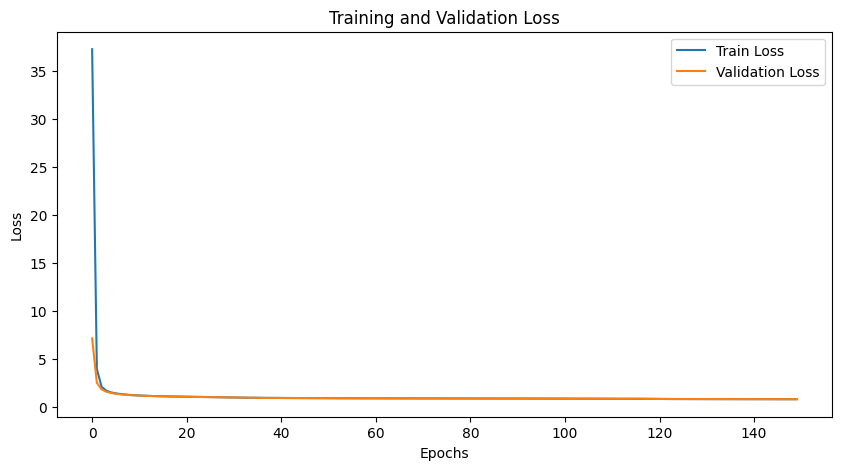

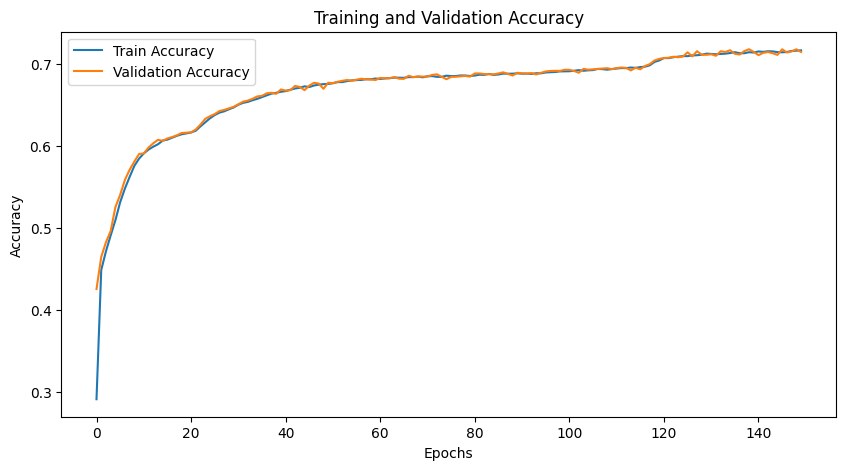

In [27]:
encoder = model.get_encoder()
for param in encoder.parameters():
    param.requires_grad = False
classifier = EncoderClassifier(encoder,latent_dim=22,layers=[22,5],subset_size=18,overlap=6,activation=torch.nn.ELU)
classifier = classifier.to(device)
print(classifier)
train_loss,val_loss,t_acc,v_acc=train_classifier(classifier,CustomLoss(100,no_of_class=5),torch.optim.Adam,150,Noise_Low_t10v_test_loader,Noise_Low_t10v_test_loader,subset_size = 18,overlap = 6)

Validation Epoch 0: 100%|██████████| 98/98 [00:00<00:00, 113.55it/s]


Epoch [0/50], Train Loss: 0.07371553390746555, Validation Loss: 0.04260723713116768


Validation Epoch 1: 100%|██████████| 98/98 [00:00<00:00, 104.71it/s]


Epoch [1/50], Train Loss: 0.04054646914114411, Validation Loss: 0.03937551667674994


Validation Epoch 2: 100%|██████████| 98/98 [00:01<00:00, 74.17it/s]


Epoch [2/50], Train Loss: 0.03682137937553657, Validation Loss: 0.031037434429312363


Validation Epoch 3: 100%|██████████| 98/98 [00:00<00:00, 136.17it/s]


Epoch [3/50], Train Loss: 0.03042834339691744, Validation Loss: 0.03000194484797808


Validation Epoch 4: 100%|██████████| 98/98 [00:00<00:00, 109.32it/s]


Epoch [4/50], Train Loss: 0.029655468547179435, Validation Loss: 0.029411017780120556


Validation Epoch 5: 100%|██████████| 98/98 [00:00<00:00, 125.27it/s]


Epoch [5/50], Train Loss: 0.029320638952552915, Validation Loss: 0.029235292913822028


Validation Epoch 6: 100%|██████████| 98/98 [00:00<00:00, 108.43it/s]


Epoch [6/50], Train Loss: 0.02916721556819259, Validation Loss: 0.028993538805307487


Validation Epoch 7: 100%|██████████| 98/98 [00:00<00:00, 128.89it/s]


Epoch [7/50], Train Loss: 0.028926811787711743, Validation Loss: 0.029081448224874643


Validation Epoch 8: 100%|██████████| 98/98 [00:00<00:00, 106.86it/s]


Epoch [8/50], Train Loss: 0.028723004211758215, Validation Loss: 0.02875431555394943


Validation Epoch 9: 100%|██████████| 98/98 [00:00<00:00, 124.91it/s]


Epoch [9/50], Train Loss: 0.028653476677927524, Validation Loss: 0.028733397494906034


Validation Epoch 10: 100%|██████████| 98/98 [00:00<00:00, 123.66it/s]


Epoch [10/50], Train Loss: 0.02852812868681772, Validation Loss: 0.028523028345826346


Validation Epoch 11: 100%|██████████| 98/98 [00:00<00:00, 128.23it/s]


Epoch [11/50], Train Loss: 0.028492600784654945, Validation Loss: 0.028349452752333422


Validation Epoch 12: 100%|██████████| 98/98 [00:00<00:00, 102.73it/s]


Epoch [12/50], Train Loss: 0.028510497682966675, Validation Loss: 0.02848386868643455


Validation Epoch 13: 100%|██████████| 98/98 [00:01<00:00, 96.43it/s] 


Epoch [13/50], Train Loss: 0.02844496137568524, Validation Loss: 0.02837924906649651


Validation Epoch 14: 100%|██████████| 98/98 [00:00<00:00, 151.15it/s]


Epoch [14/50], Train Loss: 0.028442418784834445, Validation Loss: 0.028737765101668162


Validation Epoch 15: 100%|██████████| 98/98 [00:00<00:00, 135.44it/s]


Epoch [15/50], Train Loss: 0.028436794233036775, Validation Loss: 0.028596059586375188


Validation Epoch 16: 100%|██████████| 98/98 [00:00<00:00, 118.92it/s]


Epoch [16/50], Train Loss: 0.0284479764198365, Validation Loss: 0.028435872552486568


Validation Epoch 17: 100%|██████████| 98/98 [00:00<00:00, 135.38it/s]


Epoch [17/50], Train Loss: 0.02838241126730095, Validation Loss: 0.0282697032755002


Validation Epoch 18: 100%|██████████| 98/98 [00:01<00:00, 58.07it/s] 


Epoch [18/50], Train Loss: 0.028366749279368192, Validation Loss: 0.028351867418640698


Validation Epoch 19: 100%|██████████| 98/98 [00:00<00:00, 112.21it/s]


Epoch [19/50], Train Loss: 0.028385984200539473, Validation Loss: 0.028249274824674313


Validation Epoch 20: 100%|██████████| 98/98 [00:00<00:00, 131.01it/s]


Epoch [20/50], Train Loss: 0.028340740488671985, Validation Loss: 0.028365909623411987


Validation Epoch 21: 100%|██████████| 98/98 [00:00<00:00, 126.32it/s]


Epoch [21/50], Train Loss: 0.028353248764641393, Validation Loss: 0.028305650387818997


Validation Epoch 22: 100%|██████████| 98/98 [00:01<00:00, 82.62it/s] 


Epoch [22/50], Train Loss: 0.028405148407984644, Validation Loss: 0.02834455390007068


Validation Epoch 23: 100%|██████████| 98/98 [00:00<00:00, 106.88it/s]


Epoch [23/50], Train Loss: 0.028360956304076795, Validation Loss: 0.028376124159265787


Validation Epoch 24: 100%|██████████| 98/98 [00:00<00:00, 103.90it/s]


Epoch [24/50], Train Loss: 0.02833841750711704, Validation Loss: 0.028658861714677932


Validation Epoch 25: 100%|██████████| 98/98 [00:01<00:00, 69.93it/s]


Epoch [25/50], Train Loss: 0.028325801407798935, Validation Loss: 0.028403221796720456


Validation Epoch 26: 100%|██████████| 98/98 [00:01<00:00, 59.94it/s]


Epoch [26/50], Train Loss: 0.028322896317172892, Validation Loss: 0.028326414095667694


Validation Epoch 27: 100%|██████████| 98/98 [00:00<00:00, 116.87it/s]


Epoch [27/50], Train Loss: 0.02836564883928543, Validation Loss: 0.028208098235802774


Validation Epoch 28: 100%|██████████| 98/98 [00:00<00:00, 120.69it/s]


Epoch [28/50], Train Loss: 0.028293899561947163, Validation Loss: 0.028208230684200922


Validation Epoch 29: 100%|██████████| 98/98 [00:00<00:00, 114.89it/s]


Epoch [29/50], Train Loss: 0.02827752031197843, Validation Loss: 0.028303558169267117


Validation Epoch 30: 100%|██████████| 98/98 [00:00<00:00, 119.16it/s]


Epoch [30/50], Train Loss: 0.028299998282678783, Validation Loss: 0.028329005751472253


Validation Epoch 31: 100%|██████████| 98/98 [00:00<00:00, 129.25it/s]


Epoch [31/50], Train Loss: 0.02827971594897696, Validation Loss: 0.028225853523382773


Validation Epoch 32: 100%|██████████| 98/98 [00:00<00:00, 104.84it/s]


Epoch [32/50], Train Loss: 0.028317532898001492, Validation Loss: 0.02824417859888994


Validation Epoch 33: 100%|██████████| 98/98 [00:01<00:00, 92.75it/s] 


Epoch [33/50], Train Loss: 0.02830847663743696, Validation Loss: 0.02835475938060345


Validation Epoch 34: 100%|██████████| 98/98 [00:00<00:00, 133.81it/s]


Epoch [34/50], Train Loss: 0.02827280842981194, Validation Loss: 0.028368953749155386


Validation Epoch 35: 100%|██████████| 98/98 [00:01<00:00, 96.06it/s] 


Epoch [35/50], Train Loss: 0.028246010000704046, Validation Loss: 0.028201364229122797


Validation Epoch 36: 100%|██████████| 98/98 [00:00<00:00, 121.73it/s]


Epoch [36/50], Train Loss: 0.028291532937705945, Validation Loss: 0.02829953861924318


Validation Epoch 37: 100%|██████████| 98/98 [00:00<00:00, 145.20it/s]


Epoch [37/50], Train Loss: 0.028224910713899404, Validation Loss: 0.028218222552767167


Validation Epoch 38: 100%|██████████| 98/98 [00:01<00:00, 91.68it/s] 


Epoch [38/50], Train Loss: 0.028318582981741294, Validation Loss: 0.028482334497265328


Validation Epoch 39: 100%|██████████| 98/98 [00:00<00:00, 125.48it/s]


Epoch [39/50], Train Loss: 0.028264668977592524, Validation Loss: 0.028175939867893855


Validation Epoch 40: 100%|██████████| 98/98 [00:00<00:00, 122.30it/s]


Epoch [40/50], Train Loss: 0.02818573433764052, Validation Loss: 0.028292387781234888


Validation Epoch 41: 100%|██████████| 98/98 [00:00<00:00, 113.64it/s]


Epoch [41/50], Train Loss: 0.028174567589676604, Validation Loss: 0.02820489795353168


Validation Epoch 42: 100%|██████████| 98/98 [00:00<00:00, 117.16it/s]


Epoch [42/50], Train Loss: 0.028156976928212084, Validation Loss: 0.028288629937630434


Validation Epoch 43: 100%|██████████| 98/98 [00:00<00:00, 123.47it/s]


Epoch [43/50], Train Loss: 0.02813571370475424, Validation Loss: 0.028113113830869015


Validation Epoch 44: 100%|██████████| 98/98 [00:00<00:00, 121.13it/s]


Epoch [44/50], Train Loss: 0.02811083031366042, Validation Loss: 0.02820579202320331


Validation Epoch 45: 100%|██████████| 98/98 [00:00<00:00, 123.94it/s]


Epoch [45/50], Train Loss: 0.028088489504089244, Validation Loss: 0.0278951597901491


Validation Epoch 46: 100%|██████████| 98/98 [00:00<00:00, 119.32it/s]


Epoch [46/50], Train Loss: 0.028131048567070722, Validation Loss: 0.028046463601864302


Validation Epoch 47: 100%|██████████| 98/98 [00:00<00:00, 131.44it/s]


Epoch [47/50], Train Loss: 0.028072501718550205, Validation Loss: 0.02820269702336727


Validation Epoch 48: 100%|██████████| 98/98 [00:00<00:00, 99.85it/s] 


Epoch [48/50], Train Loss: 0.028051931702439338, Validation Loss: 0.028015528093927947


Validation Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 107.49it/s]


Epoch [49/50], Train Loss: 0.028033138415850818, Validation Loss: 0.028115711838771134


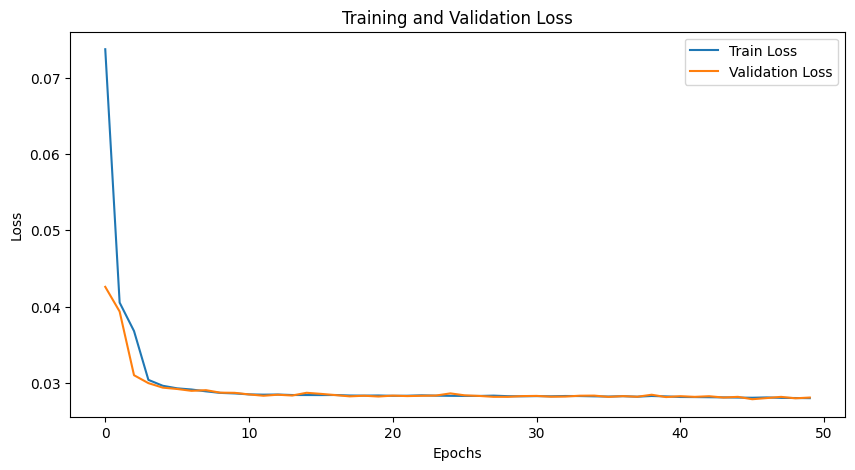

([0.07371553390746555,
  0.04054646914114411,
  0.03682137937553657,
  0.03042834339691744,
  0.029655468547179435,
  0.029320638952552915,
  0.02916721556819259,
  0.028926811787711743,
  0.028723004211758215,
  0.028653476677927524,
  0.02852812868681772,
  0.028492600784654945,
  0.028510497682966675,
  0.02844496137568524,
  0.028442418784834445,
  0.028436794233036775,
  0.0284479764198365,
  0.02838241126730095,
  0.028366749279368192,
  0.028385984200539473,
  0.028340740488671985,
  0.028353248764641393,
  0.028405148407984644,
  0.028360956304076795,
  0.02833841750711704,
  0.028325801407798935,
  0.028322896317172892,
  0.02836564883928543,
  0.028293899561947163,
  0.02827752031197843,
  0.028299998282678783,
  0.02827971594897696,
  0.028317532898001492,
  0.02830847663743696,
  0.02827280842981194,
  0.028246010000704046,
  0.028291532937705945,
  0.028224910713899404,
  0.028318582981741294,
  0.028264668977592524,
  0.02818573433764052,
  0.028174567589676604,
  0.02815

In [28]:
model = SubsetAutoencoder(encoder_sizes=[18,32,22],decoder_sizes=[22,32,24])
model.to(device)
optimizer = torch.optim.Adam
criterion = torch.nn.MSELoss()
train_ae(model,criterion,optimizer,50,Noise_High_t10v_train_loader,Noise_High_t10v_test_loader,subset_size = 18,overlap = 6,lr=0.01)

Validation Epoch 139: 100%|██████████| 98/98 [00:00<00:00, 111.28it/s]


Epoch [140/150], Train Loss: 1.1799, Train Accuracy: 0.5182, Validation Loss: 1.1816, Validation Accuracy: 0.5170


Validation Epoch 140: 100%|██████████| 98/98 [00:01<00:00, 91.85it/s] 


Epoch [141/150], Train Loss: 1.1803, Train Accuracy: 0.5187, Validation Loss: 1.1799, Validation Accuracy: 0.5154


Validation Epoch 141: 100%|██████████| 98/98 [00:01<00:00, 72.47it/s]


Epoch [142/150], Train Loss: 1.1803, Train Accuracy: 0.5189, Validation Loss: 1.1792, Validation Accuracy: 0.5188


Validation Epoch 142: 100%|██████████| 98/98 [00:01<00:00, 68.00it/s]


Epoch [143/150], Train Loss: 1.1796, Train Accuracy: 0.5191, Validation Loss: 1.1796, Validation Accuracy: 0.5188


Validation Epoch 143: 100%|██████████| 98/98 [00:01<00:00, 97.80it/s] 


Epoch [144/150], Train Loss: 1.1797, Train Accuracy: 0.5198, Validation Loss: 1.1795, Validation Accuracy: 0.5180


Validation Epoch 144: 100%|██████████| 98/98 [00:01<00:00, 75.32it/s]


Epoch [145/150], Train Loss: 1.1793, Train Accuracy: 0.5198, Validation Loss: 1.1789, Validation Accuracy: 0.5196


Validation Epoch 145: 100%|██████████| 98/98 [00:01<00:00, 88.11it/s]


Epoch [146/150], Train Loss: 1.1797, Train Accuracy: 0.5186, Validation Loss: 1.1794, Validation Accuracy: 0.5186


Validation Epoch 146: 100%|██████████| 98/98 [00:01<00:00, 65.00it/s]


Epoch [147/150], Train Loss: 1.1800, Train Accuracy: 0.5191, Validation Loss: 1.1797, Validation Accuracy: 0.5195


Validation Epoch 147: 100%|██████████| 98/98 [00:00<00:00, 104.71it/s]


Epoch [148/150], Train Loss: 1.1803, Train Accuracy: 0.5189, Validation Loss: 1.1808, Validation Accuracy: 0.5189


Validation Epoch 148: 100%|██████████| 98/98 [00:01<00:00, 82.23it/s] 


Epoch [149/150], Train Loss: 1.1800, Train Accuracy: 0.5182, Validation Loss: 1.1791, Validation Accuracy: 0.5199


Validation Epoch 149: 100%|██████████| 98/98 [00:01<00:00, 86.46it/s]


Epoch [150/150], Train Loss: 1.1801, Train Accuracy: 0.5189, Validation Loss: 1.1801, Validation Accuracy: 0.5179


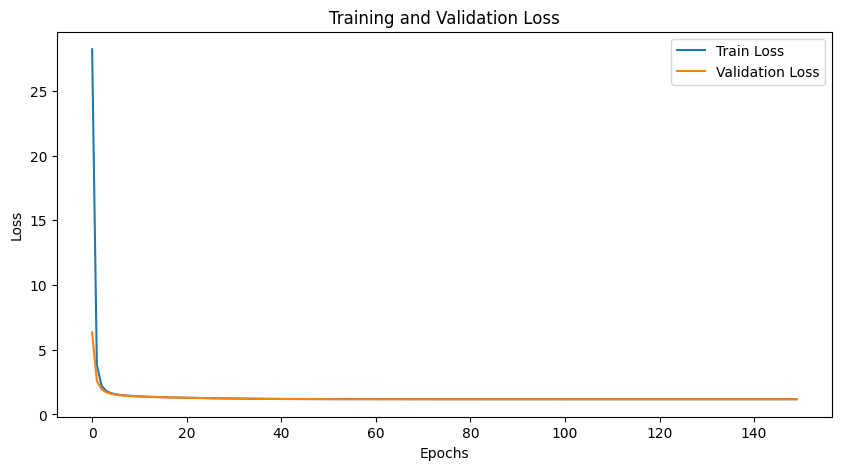

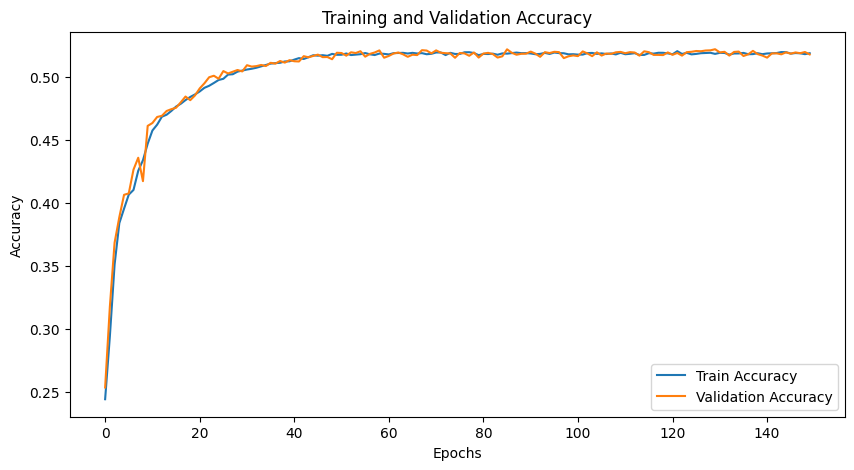

In [29]:
encoder = model.get_encoder()
for param in encoder.parameters():
    param.requires_grad = False
classifier = EncoderClassifier(encoder,latent_dim=22,layers=[22,5],subset_size=18,overlap=6,activation=torch.nn.ELU)
classifier = classifier.to(device)
print(classifier)
train_loss,val_loss,t_acc,v_acc=train_classifier(classifier,CustomLoss(100,no_of_class=5),torch.optim.Adam,150,Noise_High_t10v_test_loader,Noise_High_t10v_test_loader,subset_size = 18,overlap = 6)

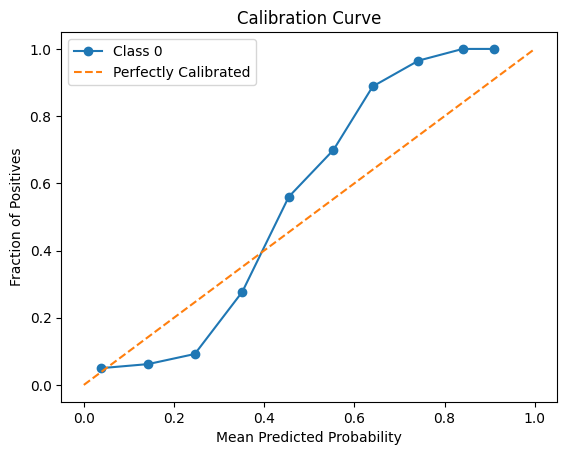

In [21]:
# Choose Class
cls=0
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch

def binarize(target, c):
    return np.array([1 if t == c else 0 for t in target])

Model=classifier
Model.eval()  # Set model to evaluation mode
y_true = []
y_probabilities = []

# Iterate over test_loader to get predictions and true labels
for inputs, labels in Noise_test_loader:
    inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

    # Forward pass
    outputs = Model(inputs)
    probabilities = outputs[0]
    
    y_true.extend(labels.cpu().numpy())  # Collect true labels
    y_probabilities.extend(probabilities[:, 0].detach().cpu().numpy())  # Collect probabilities for class 0

y_true_binarized = binarize(y_true, 0)
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true_binarized, y_probabilities, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Class")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()